Note: I want to work on this one to really get it working well, as the manual parameter that needs to be changed in this one should be much more straight forward than in heirachical or k means clustering. It also doesn't assume spherical shapes and can identify noise.

In [34]:
import numpy as np
from random import randint, choices
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [35]:
image_dimensions = {"height": 200, "width": 200}
no_shapes = 3
shape_radius = 20
noise_level = 50 # larger -> less noise

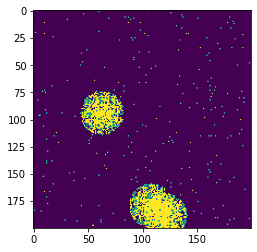

In [36]:
image = np.zeros((image_dimensions["height"], image_dimensions["width"]))

shapes = []
for i in range(no_shapes):
  centre = (randint(0, image_dimensions["width"]-1), randint(0, image_dimensions["height"]-1))
  shapes.append([centre, shape_radius])

for y in range(len(image)):
  for x in range(len(image[y])):
    for shape in shapes:
      distance = ((y - shape[0][1])**2 + (x - shape[0][0])**2)**0.5
      if distance <= shape[1] and randint(1, int(noise_level/(distance+1))) != 1 or randint(1, noise_level*10) == 1:
        image[y,x] = 1

imgplot = plt.imshow(image)

In [42]:
def DBSCAN(image, radius, core_threshold):

  points = []

  for y in range(len(image)):
    for x in range(len(image[y])):
      if image[y,x] == 1:
        points.append([(y,x), 0])

  groups = [0]  # group 0 -> noise (default)

  for point in points:

    surrounding_points = []
    for other_point in points:
      if ((point[0][0] - other_point[0][0])**2 + (point[0][1] - other_point[0][1])**2)**0.5 <= radius and point != other_point:
        surrounding_points.append(other_point)
    
    if len(surrounding_points) >= core_threshold:

      if sum([p[1] for p in surrounding_points]) == 0:  # no groups
        new_group = groups[-1] + 1
        groups.append(new_group)

        for p in surrounding_points:
          p[1] = new_group  # changes main points list as list is reference

      elif sum([p[1]>0 for p in surrounding_points]) == 1:  # one group
        
        group = -1  # group should never stay -1
        for p in surrounding_points:
            group = p[1] if p[1] > 0 else group

        for p in surrounding_points:
          p[1] = group

      else:  # >1 group

        surrounding_groups = []
        for p in surrounding_points:
            if p[1] not in surrounding_groups and p[1] != 0:
              surrounding_groups.append(p[1])

        for p in surrounding_points:
          p[1] = surrounding_groups[0]

        for p in points:
          if p[1] in surrounding_groups:
            p[1] = surrounding_groups[0]

  del groups[0]  # noise group
  centres = [[0, 0] for i in groups]
  totals = [0 for i in groups]

  for point in points:
    if point[1] != 0:
      centres[groups.index(point[1])][0] += point[0][0]
      centres[groups.index(point[1])][1] += point[0][1]
      totals[groups.index(point[1])] += 1

  for i in range(len(groups)):
    if totals[i] > 0:
      centres[i][0] /= totals[i]
      centres[i][1] /= totals[i]

  loss = 0
  for point in points:
    distances = np.array([((point[0][0] - centre[0])**2 + (point[0][1] - centre[1])**2)**0.5 for centre in centres])
    loss += min(distances)

  del_list = []
  for i in range(len(centres)):
    if centres[i] == [0, 0]:
      del_list.append(i)
  for i in sorted(del_list)[::-1]: del centres[i]

  return points, centres, loss

No. objects: 2
Centres:  (62.95, 93.91), (114.06, 181.8)


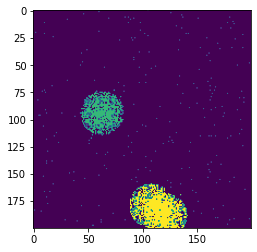

In [43]:
points, centres, loss = DBSCAN(image, 5, 5)

temp_image = np.zeros((image_dimensions["height"], image_dimensions["width"]))
for point in points:
  temp_image[point[0][0], point[0][1]] = point[1] + 1
imgplot = plt.imshow(temp_image)

print(f"No. objects: {len(centres)}\nCentres: " + "".join([f", ({round(centre[1], 2)}, {round(centre[0], 2)})" for centre in centres])[1:])

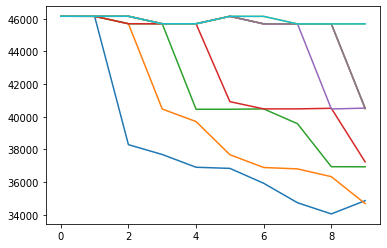

In [89]:
a_range = b_range = [i+4 for i in range(10)]

loss = []
for a in a_range:
  temp_loss = []
  for b in b_range:
    temp_loss.append(DBSCAN(image, a, b)[2])
  loss.append(temp_loss)
plt.plot(loss)

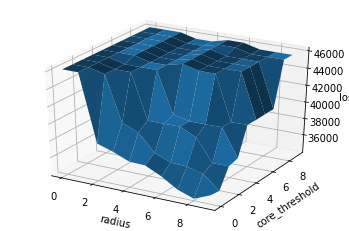

In [90]:
def fun(x, y):
    return np.array(loss)[x,y]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = y = np.array(list(range(len(b_range))))
X, Y = np.meshgrid(x, y)
zs = np.array(fun(np.ravel(X), np.ravel(Y)))
Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z)

ax.set_xlabel('radius')
ax.set_ylabel('core_threshold')
ax.set_zlabel('loss')

plt.show()